In [6]:
import sys
sys.path.insert(0, 'env')

import ccg
import pandas as pd
import numpy as np
import copy
import random
import torch
seed = 12345644

np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

cards = pd.read_csv('env/configue/cardsTable.csv')
cardsList = [ccg.Minion(i) for i in cards.values.tolist()]

cores = pd.read_csv('env/configue/cores.csv')
coreList = [ccg.Core(i) for i in cores.values.tolist()]

playersNum = 2
piles = [[ccg.Pile(cardsList, 10) for _ in range(4)] for I in range(playersNum)]
cores = np.random.choice(coreList, 2)
decks = [ccg.Deck(cores[i], piles[i], i) for i in range(playersNum)]

In [7]:
session = ccg.Session(decks)

In [8]:
from __future__ import print_function
print(torch.__version__)

0.4.1


In [4]:
def observationMinion(minion):
    state = list(minion)
    state[5] = int(state[5])
    return np.array(state)

CARD_SIZE = len(observationMinion(ccg.Minion().getCurState()))

In [5]:
def observationTable(table, turn):
    tables = copy.deepcopy(table)
    for i in tables:
        #TODO : don't calc empty minions
        for j in range(len(i), 8):
            i.append(np.array([-1] * CARD_SIZE))
        i[0] = observationCore(i[0])
        for j in range(1, len(i)):
            i[j] = observationMinion(i[j])
        buf = i[1:]
        #random.shuffle(buf)
        i[1:] = buf
    tables[0], tables[turn] = tables[turn], tables[0]
    tables_copy = copy.deepcopy(tables)
    
    for i in range(len(tables)):
        tables[i] = np.hstack(tuple(tables[i]))
        for j in range(len(tables_copy[i])):
            tables_copy[i][j] = tables_copy[i][j].tolist()
    return np.hstack(tuple(tables)), tables_copy

def observationCore(core):
    return np.array(list(core))

def observationPile(pile):
    pileCopy = copy.deepcopy(pile)
    #random.shuffle(pileCopy)
    for i in range(len(pileCopy)):
        pileCopy[i] = list(pileCopy[i])
        if pileCopy[i][1] == None:
            pileCopy[i][1] = np.array([-1] * CARD_SIZE)
        else:
            pileCopy[i][1] = observationMinion(pileCopy[i][1])
        pileCopy[i] = [pileCopy[i][0]] + pileCopy[i][1].tolist()
    return np.hstack(tuple(pileCopy)), pileCopy

def observationHand(hand):
    handCopy = copy.deepcopy(hand)
    #random.shuffle(pileCopy)
    for i in range(len(hand[1]), 6):
        handCopy[1].append(None)
    for i in range(len(handCopy[1])):
        if handCopy[1][i] == None:
            handCopy[1][i] = np.array([-1] * CARD_SIZE)
        else:
            handCopy[1][i] = observationMinion(handCopy[1][i])
    return [handCopy[0]] + np.hstack(tuple(handCopy[1])), handCopy[1]

def createStateObservation(state):
    
    observations = dict()
    observations["table"], tables = observationTable(state["battleGround"]["table"], state["turn"])
    observations["piles"] = []
    observations["hands"] = []
    pilesObs = []
    handsObs = []
    
    for i in state["piles"]:
        obs, obj = observationPile(i)
        observations["piles"].append(obj)
        pilesObs.append(obs)
        
    for i in state["hands"]:
        obs, obj = observationHand(i)
        observations["hands"].append(obj)
        handsObs.append(obs)
    observations["hands"][0], observations["hands"][state["turn"]] = observations["hands"][state["turn"]], observations["hands"][0]
    handsObs[0], handsObs[state["turn"]] = handsObs[state["turn"]], handsObs[0]
    handsObs = np.hstack(tuple(handsObs))
    
    observations["piles"][0], observations["piles"][state["turn"]] = observations["piles"][state["turn"]], observations["piles"][0]
    pilesObs[0], pilesObs[state["turn"]] = pilesObs[state["turn"]], pilesObs[0]
    pilesObs = np.hstack(tuple(pilesObs))
    
    observations["main"] = observations["table"].tolist() + pilesObs.tolist() + handsObs.tolist()
    
    cores = []
    units = []
    for i in tables:
        cores.append(i[0])
        units.append(i[1:])

    observations["cores"] = cores
    observations["units"] = units
    
    return observations


In [6]:
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ActorNetwork(nn.Module):
    def __init__(self, MAIN_SIZE, CARD_SIZE, CORE_SIZE, PILE_SIZE, HAND_SIZE, VEC_SIZE, epsilon = 0.5):
        super().__init__()
        self.epsilon = epsilon
        
        self.field2vec = nn.Sequential(
            nn.Linear(MAIN_SIZE, 512,), 
            nn.ELU(), 
            nn.Linear(512, VEC_SIZE))
        
        self.skip_qvalue = nn.Sequential(
            nn.Linear(MAIN_SIZE, 512,), 
            nn.ELU(), 
            nn.Linear(512, 1))
        
        self.card2vec = nn.Sequential(
            nn.Linear(CARD_SIZE, 512,), 
            nn.ELU(), 
            nn.Linear(512, VEC_SIZE))
        
        self.attack_units_qvalues = nn.Sequential(
            nn.Linear(VEC_SIZE, 512,),  #[field, attacker_card, target_card]
            nn.ELU(), 
            nn.Linear(512, 1))
        
        self.core2vec = nn.Sequential(
            nn.Linear(CORE_SIZE, 512,), 
            nn.ELU(), 
            nn.Linear(512, VEC_SIZE))
        
        self.pile2vec = nn.Sequential(
            nn.Linear(PILE_SIZE, 512,), 
            nn.ELU(), 
            nn.Linear(512, VEC_SIZE))
        
        self.hand2vec = nn.Sequential(
            nn.Linear(HAND_SIZE, 512,), 
            nn.ELU(), 
            nn.Linear(512, VEC_SIZE))
        
        self.attack_core_qvalues = nn.Sequential(
            nn.Linear(VEC_SIZE, 512,),  #[field, attacker_card, core]
            nn.ELU(), 
            nn.Linear(512, 1))
        
        self.play_card_qvalues = nn.Sequential(
            nn.Linear(VEC_SIZE, 512,),  #[field, pile]
            nn.ELU(), 
            nn.Linear(512, 1))
        
        self.play_hand_card_qvalues = nn.Sequential(
            nn.Linear(VEC_SIZE, 512,),  #[field, hand]
            nn.ELU(), 
            nn.Linear(512, 1))
        
        self.move_card_qvalues = nn.Sequential(
            nn.Linear(VEC_SIZE, 512,),  #[field, pile]
            nn.ELU(), 
            nn.Linear(512, 1))
    
    def parse_state(self, state):
        main = np.array(state["main"], dtype=np.float32)[None, None, None, :]
        our_units = np.array(state["units"][0], dtype=np.float32)[None, :, None, :]
        enemy_units = np.array(state["units"][1], dtype=np.float32)[None, None, :, :]
        enemy_core = np.array([state["cores"][1]], dtype=np.float32)[None, None, :]
        our_piles = np.array(state["piles"][0], dtype=np.float32)[None, :, None, :]
        our_hand = np.array(state["hands"][0], dtype=np.float32)[None, None, :]
        return main, our_units, enemy_units, enemy_core, our_piles, our_hand
    
    def get_qvalues_from_state(self, state):
        main, our_units, enemy_units, enemy_core, our_piles, our_hand = self.parse_state(state)
        main = np.array([main])
        enemy_units = np.array([enemy_units])
        enemy_core = np.array([enemy_core])
        our_piles = np.array([our_piles])
        our_units = np.array([our_units])
        our_hand = np.array([our_hand])
        return self.forward(main, our_units, enemy_units, enemy_core, our_piles, our_hand)
        
    def forward(self, main, our_units, enemy_units, enemy_core, our_piles, our_hand):
        
        qvalues = self.compute_qvalue(
            torch.from_numpy(main),
            torch.from_numpy(our_units),
            torch.from_numpy(enemy_units),
            torch.from_numpy(enemy_core),
            torch.from_numpy(our_piles),
            torch.from_numpy(our_hand)
        )
        
        return qvalues
    
    def record():
        pass
    
    def compute_qvalue(self, field, card, target_card, core, pile, hand):
        field_vec = self.field2vec(field)
        card_vec = self.card2vec(card)
        target_vec = self.card2vec(target_card)
        pile_vec = self.pile2vec(pile)
        core_vec = self.core2vec(core)
        hand_vec = self.hand2vec(hand)
        
        batch_size = len(core)
        #print(hand_vec.shape)
        #print(field_vec.shape, card_vec.shape, target_vec.shape)
        attack_units_qvalue = self.attack_units_qvalues(field_vec + card_vec + target_vec)
        #print(attack_units_qvalue.shape)
        attack_units_qvalue = attack_units_qvalue.view(-1)
        attack_units_qvalue = attack_units_qvalue.view(batch_size, len(attack_units_qvalue) // batch_size)
        #print(attack_units_qvalue.shape[1] == 49)
        
        #print(field_vec.shape, card_vec.shape, core_vec.shape)
        attack_core_qvalue = self.attack_core_qvalues(field_vec + card_vec + core_vec)
        #print(attack_core_qvalue.shape)
        attack_core_qvalue = attack_core_qvalue.view(-1)
        attack_core_qvalue = attack_core_qvalue.view(batch_size, len(attack_core_qvalue) // batch_size)
        #print(attack_core_qvalue.shape[1] == 7)
        
        play_card_qvalue = self.play_card_qvalues(field_vec + pile_vec).view(-1)
        play_card_qvalue = play_card_qvalue.view(batch_size, len(play_card_qvalue) // batch_size)
        #print(play_card_qvalue.shape[1] == 4)
        
        skip_qvalue = self.skip_qvalue(field).view(-1)
        skip_qvalue = skip_qvalue.view(batch_size, len(skip_qvalue) // batch_size)
        #print(skip_qvalue.shape[1] == 1)
        
        play_hand_card_qvalue = self.play_hand_card_qvalues(field_vec + hand_vec).view(-1)
        play_hand_card_qvalue = play_hand_card_qvalue.view(batch_size, len(play_hand_card_qvalue) // batch_size)
        #print(play_hand_card_qvalue.shape[1])
        
        move_card_qvalue = self.move_card_qvalues(field_vec + pile_vec).view(-1)
        move_card_qvalue = move_card_qvalue.view(batch_size, len(move_card_qvalue) // batch_size)
        #print(move_card_qvalue.shape[1])
        
        return torch.cat((skip_qvalue, 
                          attack_core_qvalue, 
                          attack_units_qvalue, 
                          play_card_qvalue, 
                          play_hand_card_qvalue,
                          move_card_qvalue
                         ), dim=1)
    
    def sample_actions(self, qvalues, valid_actions):
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        
        #print(qvalues.shape, valid_actions.shape)
        
        qvalues[np.logical_not(valid_actions)] = -2**32
        valid_actions = valid_actions.astype(np.int)
        valid_actions = [va / np.sum(va) for va in valid_actions]
        random_actions = [np.random.choice(n_actions, size=batch_size, p=va)[0] for va in valid_actions]
        best_actions = qvalues.argmax(axis=-1)
        
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

state = createStateObservation(session.reset())
MAIN_SIZE = len(state["main"])
CARD_SIZE = len(observationMinion(ccg.Minion().getCurState()))
CORE_SIZE = len(state["cores"][0])
PILE_SIZE = len(state["piles"][0][0])
HAND_SIZE = len(state["hands"][0])
VEC_SIZE = 100

actor_network = ActorNetwork(MAIN_SIZE, CARD_SIZE, CORE_SIZE, PILE_SIZE, HAND_SIZE, VEC_SIZE)
actor_network_optim = torch.optim.Adam(actor_network.parameters(), lr = 0.01)

#[FIELD_INDEX, OUR_CARD_INDEX, TARGET_CARD_INDEX, VEC]
main, our_units, enemy_units, enemy_core, our_piles, our_hand = actor_network.parse_state(state)
qvalues = actor_network(np.array([main]),
                                 np.array([our_units]),
                                 np.array([enemy_units]),
                                 np.array([enemy_core]),
                                 np.array([our_piles]),
                                 np.array([our_hand])
                       )
print(qvalues)
main = np.array([main, main])
our_units = np.array([our_units, our_units])
enemy_units = np.array([enemy_units, enemy_units])
enemy_core = np.array([enemy_core, enemy_core])
our_piles = np.array([our_piles, our_piles])
our_hand = np.array([our_hand, our_hand])
qvalues = actor_network(main, our_units, enemy_units, enemy_core, our_piles, our_hand)
qvalues

tensor([[-0.0147,  0.1616,  0.1616,  0.1616,  0.1616,  0.1616,  0.1616,  0.1616,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281, -0.3140, -0.3260, -0.3140, -0.3140,  0.0533,  0.0533,  0.0533,
          0.0533,  0.0533,  0.0533, -0.0710, -0.0408, -0.0710, -0.0710]],
       grad_fn=<CatBackward>)


tensor([[-0.0147,  0.1616,  0.1616,  0.1616,  0.1616,  0.1616,  0.1616,  0.1616,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281, -0.3140, -0.3260, -0.3140, -0.3140,  0.0533,  0.0533,  0.0533,
          0.0533,  0.0533,  0.0533, -0.0710, -0.0408, -0.0710, -0.0710],
        [-0.0147,  0.1616,  0.1616,  0.1616,  0.1616,  0.1616,  0.1616,  0.1616,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,  0.2281,
          0.2281,  0.2281,  0.2281, 

In [7]:
len(qvalues[0])

71

In [8]:
main, our_units, enemy_units, enemy_core, our_piles, our_hand = actor_network.parse_state(state)
qvalues = actor_network(np.array([main]),
                                 np.array([our_units]),
                                 np.array([enemy_units]),
                                 np.array([enemy_core]),
                                 np.array([our_piles]),
                                 np.array([our_hand])
                       )
def envActionFromAction(action, home_turn):
    #skip
    env_action = ("skip")
    if action == 0:
        return env_action
    
    #attack core
    action -= 1
    if(action < 7):
        env_action = ("attack", [home_turn, action], [1 - home_turn, 0])
        return env_action
    
    #attack unit
    action -= 7
    if(action < 49):
        env_action = ("attack", [home_turn, action // 7], [1 - home_turn, action % 7])
        return env_action
    
    #play from pile
    action -= 49
    if(action < 4):
        env_action = ("play", action)
        return env_action
    
    #play from hand
    action -= 4
    if(action < 6):
        env_action = ("play_hand", action)
        return env_action
    
    #move from pile to hand
    action -= 6
    env_action = ("move", action)
    if action < 4:
        return env_action
    return None

home_turn = 0
valid_actions = [[]]
actions = session.getValidActions()
n_actions = 1 + 7 * 8 + 4 + 6 + 4
for i in range(n_actions):
    env_action = envActionFromAction(i, home_turn)
    valid_actions[0].append(env_action in actions)

print(valid_actions)
#get valid action from network
action = actor_network.sample_actions(qvalues.detach().numpy(), np.array(valid_actions))[0]
action

[[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, True, True, True]]


58

In [9]:
class ValueNetwork(nn.Module):

    def __init__(self, MAIN_SIZE):
        super(ValueNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(MAIN_SIZE, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state_t):
        reward = self.layers(state_t)
        reward = reward.reshape(reward.shape[0])
        return reward

In [10]:
value_network = ValueNetwork(MAIN_SIZE)
value_network_optim = torch.optim.Adam(value_network.parameters(), lr=0.01)

In [11]:
def discount_reward(r, gamma, final_r):
    discounted_r = np.zeros_like(r)
    running_add = final_r
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [12]:
import numpy
import random

def play_and_record(agent, session, n_steps = 1000, home_turn=0):
    rewards = 0
    
    all_actions = []
    for i in range(n_actions):
        all_actions.append(envActionFromAction(i, home_turn))
    
    states_log = []
    actions_log = []
    rewards_log = []
    final_state = None
    final_r = 0
    state = session.getObservation()
    is_done = False
    
    for i in range(n_steps):
        
        table = session.getObservation()["battleGround"]["table"]
        hits_diff = table[home_turn][0][2] - table[1 - home_turn][0][2]
        
        state = createStateObservation(state)
        
        states_log.append(agent.parse_state(state))
        #get actions
        actions = session.getValidActions()
        log_softmax_action = agent.get_qvalues_from_state(state)
        softmax_action = torch.exp(log_softmax_action)
        qvalues = softmax_action.data.cpu().numpy()
        
        valid_actions = [[]]
        for i in all_actions:
            valid_actions[0].append(i in actions)
            
            
        #get valid action from network
        action = agent.sample_actions(qvalues, np.array(valid_actions))[0]
        one_hot_action = [int(k == action) for k in range(n_actions)]
        actions_log.append(one_hot_action)
        
        #step
        env_action = envActionFromAction(action, home_turn)
        next_s = session.action(env_action)
        
        endGame = next_s["end"]
        
        #enemy turn
        if (next_s["turn"] != home_turn) and not endGame:
            actions = session.getValidActions()
            while len(actions) > 1 and not endGame:  
                next_s = session.action(random.choice(actions[1:]))
                actions = session.getValidActions()
                endGame = next_s["end"]
            if not endGame:
                next_s = session.action(random.choice(actions[0]))
        
        #calc reward
        table = next_s["battleGround"]["table"]
        reward = table[home_turn][0][2] - table[1 - home_turn][0][2] - hits_diff - 0.1
        rewards_log.append(reward)
        
        final_state = next_s
        
        #morph game state to network state
        
        state = next_s
        
        if endGame:
            is_done = True
            session.reset()
            break

    if not is_done:
        final_r = value_network(Variable(torch.Tensor([createStateObservation(final_state)["main"]]))).cpu().data.numpy()

    return states_log, actions_log, rewards_log, final_r, final_state

In [13]:
home_turn = 0
states, actions, rewards, final_r, _ =  play_and_record(actor_network, session, n_steps=20, home_turn=0)
print(rewards)
actions_var = Variable(torch.Tensor(actions).view(-1, n_actions))

# train actor network
actor_network_optim.zero_grad()
main = []
our_units = []
enemy_units = []
enemy_core = []
discount = 0.99
our_piles = []
our_hands = []
for i in states:
    main.append(i[0])
    our_units.append(i[1])
    enemy_units.append(i[2])
    enemy_core.append(i[3])
    our_piles.append(i[4])
    our_hands.append(i[5])
log_softmax_actions = actor_network(np.array(main), 
                                    np.array(our_units), 
                                    np.array(enemy_units), 
                                    np.array(enemy_core), 
                                    np.array(our_piles),
                                    np.array(our_hand)
                                   )

states_var = Variable(torch.Tensor(np.array(main)).view(-1, MAIN_SIZE))
vs = value_network(states_var).detach()

# calculate qs
qs = Variable(torch.Tensor(discount_reward(rewards, discount, final_r)))

advantages = qs - vs
actor_network_loss = -torch.mean(torch.sum(log_softmax_actions * actions_var, 1) * advantages)

[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -2.1, -0.1, 1.9, -0.1, -0.1, -0.1, -0.1, -0.1]


### Training

In [14]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
state = session.reset()

value_network = ValueNetwork(MAIN_SIZE)
value_network_optim = torch.optim.Adam(value_network.parameters(), lr=0.01)

actor_network = ActorNetwork(MAIN_SIZE, CARD_SIZE, CORE_SIZE, PILE_SIZE, HAND_SIZE, VEC_SIZE, epsilon = 0.1)
actor_network_optim = torch.optim.Adam(actor_network.parameters(), lr = 0.01)

discount = 0.99

home_turn = 0

mean_rewards = []
mean_hits_diff = []
mean_enemy_core_hits = []
mean_win = []
mean_loss_actor = []
mean_loss_value = []

<Figure size 432x288 with 0 Axes>

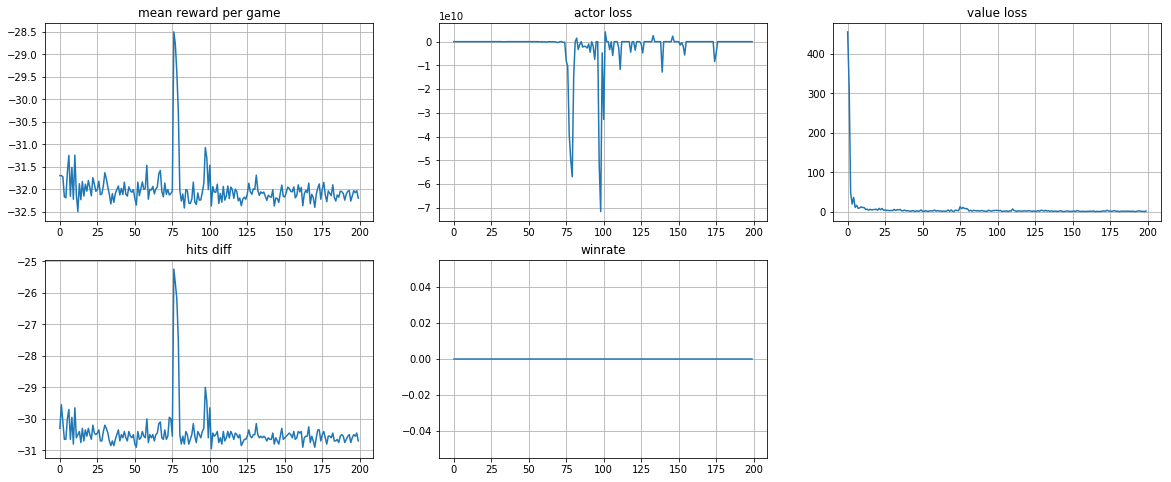

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [29:33<00:00,  1.50it/s]


<Figure size 432x288 with 0 Axes>

In [16]:
import pickle

state = session.reset()
batch_loss_actor = []
batch_loss_value = []
for i in trange(10000):
    
    
    states, actions, rewards, final_r, _ =  play_and_record(actor_network, session, n_steps=200, home_turn=0)
    
    actions_var = Variable(torch.Tensor(actions).view(-1, n_actions))
    

    # train actor network
    actor_network_optim.zero_grad()
    main = []
    our_units = []
    enemy_units = []
    enemy_core = []
    discount = 0.99
    our_piles = []
    our_hands = []
    for st in states:
        main.append(st[0])
        our_units.append(st[1])
        enemy_units.append(st[2])
        enemy_core.append(st[3])
        our_piles.append(st[4])
        our_hands.append(st[5])
    log_softmax_actions = actor_network(np.array(main), 
                                        np.array(our_units), 
                                        np.array(enemy_units), 
                                        np.array(enemy_core), 
                                        np.array(our_piles),
                                        np.array(our_hands)
                                       )

    states_var = Variable(torch.Tensor(np.array(main)).view(-1, MAIN_SIZE))
    vs = value_network(states_var).detach()
    
    # calculate qs
    qs = Variable(torch.Tensor(discount_reward(rewards, discount, final_r)))

    advantages = qs - vs
    actor_network_loss = -torch.mean(torch.sum(log_softmax_actions * actions_var, 1) * advantages)
    batch_loss_actor.append(actor_network_loss.detach().numpy())
    actor_network_loss.backward()
    torch.nn.utils.clip_grad_norm(actor_network.parameters(), 0.5)
    actor_network_optim.step()

    # train value network
    value_network_optim.zero_grad()
    target_values = qs
    values = value_network(states_var)
    criterion = nn.MSELoss()
    value_network_loss = criterion(values, target_values)
    batch_loss_value.append(value_network_loss.detach().numpy())
    value_network_loss.backward()
    torch.nn.utils.clip_grad_norm(value_network.parameters(), 0.5)
    value_network_optim.step()

    # Testing
    if (i + 1) % 50== 0:
        actor_network.epsilon *= 0.99
        
        remembered_eps = actor_network.epsilon
        
        session.reset()
        rewards_eval = []
        hits_diff = []
        wins = []
        enemy_core_hits = []

        eval_games = 20

        for j in range(eval_games):
            _, _, rewards_log, _, final_state = play_and_record(actor_network, session, n_steps=1000, home_turn=0)

            table = final_state["battleGround"]["table"]
            hits_d = table[home_turn][0][2] - table[1 - home_turn][0][2]

            enemy_core_hits.append(table[1 - home_turn][0][2])
            rewards_eval.append(np.sum(rewards_log))
            hits_diff.append(hits_d)
            wins.append(final_state["loser"] != home_turn)
        
        actor_network.epsilon = remembered_eps

        mean_enemy_core_hits.append(np.mean(enemy_core_hits))
        mean_hits_diff.append(np.mean(hits_diff))

        mean_win.append(np.count_nonzero(np.array(wins) == True) / eval_games)

        mean_rewards.append(np.mean(rewards_eval))
        mean_loss_actor.append(np.mean(batch_loss_actor))
        mean_loss_value.append(np.mean(batch_loss_value))

        batch_loss_actor = []
        batch_loss_value = []

        log_dict = dict()
        log_dict["mean_rewards"] = mean_rewards
        log_dict["mean_loss_actor"] = mean_loss_actor
        log_dict["mean_loss_value"] = mean_loss_value
        log_dict["mean_win"] = mean_win
        log_dict["mean_hits_diff"] = mean_hits_diff

        with open('log_a2c_random.pickle', 'wb') as f:
            pickle.dump(log_dict, f)
        
        with open('model_a2c_random.pickle', 'wb') as f:
            pickle.dump(actor_network, f)

        clear_output(True)

        plt.figure(figsize=[20, 8])    
        plt.subplot(2, 3, 1)
        plt.title("mean reward per game")
        plt.plot(range(len(mean_rewards)), mean_rewards)
        plt.grid()

        plt.subplot(2, 3, 2)
        plt.title("actor loss")
        plt.plot(range(len(mean_loss_actor)), mean_loss_actor)
        plt.grid()

        plt.subplot(2, 3, 3)
        plt.title("value loss")
        plt.plot(range(len(mean_loss_value)), mean_loss_value)
        plt.grid()

        plt.subplot(2, 3, 4)
        plt.title("hits diff")
        plt.plot(range(len(mean_hits_diff)), mean_hits_diff)
        #plt.plot(range(len(mean_enemy_core_hits)), mean_enemy_core_hits)
        plt.grid()

        plt.subplot(2, 3, 5)
        plt.title("winrate")
        plt.plot(range(len(mean_win)), mean_win)
        plt.grid()
        plt.show()

        plt.savefig("train.png");
    